In [ ]:
!pip install -q lightgbm pandas numpy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

##1. Importando os arquivos

In [ ]:
df27 = pd.read_parquet('part27.snappy.parquet')
df51 = pd.read_parquet('part51.snappy.parquet')
df71 = pd.read_parquet('part71.snappy.parquet')

In [ ]:
df27.info()
df51.info()
df71.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14419 entries, 0 to 14418
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   pdv            14419 non-null  object
 1   premise        14419 non-null  object
 2   categoria_pdv  14419 non-null  object
 3   zipcode        14419 non-null  int32 
dtypes: int32(1), object(3)
memory usage: 394.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6560698 entries, 0 to 6560697
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   internal_store_id    object 
 1   internal_product_id  object 
 2   distributor_id       object 
 3   transaction_date     object 
 4   reference_date       object 
 5   quantity             float64
 6   gross_value          float64
 7   net_value            float64
 8   gross_profit         float64
 9   discount             float64
 10  taxes                float64
dtypes: float64(6), object(

In [ ]:
df27.head()

,pdv,premise,categoria_pdv,zipcode
0,2204965430669363375,On Premise,Mexican Rest,30741
1,5211957289528622910,On Premise,Hotel/Motel,80011
2,9024493554530757353,Off Premise,Convenience,80751
3,8659197371382902429,On Premise,Restaurant,80439
4,1400854873763881130,On Premise,Restaurant,30093


In [ ]:
df51.head()

,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.0,38.125000,37.890625,10.042625,3.950000,0.234375
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.0,107.250000,106.440002,24.732002,17.100000,0.810000
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.0,56.625000,56.220001,14.124002,5.250000,0.405000
3,3681167389484217654,1401422983880045188,5,2022-09-11,2022-09-01,129.0,1037.160023,1037.160023,156.348026,479.880006,0.000000
4,7762413312337359369,6614994347738381720,4,2022-02-18,2022-02-01,1.0,26.230000,23.950241,6.550241,0.000000,2.279758


In [ ]:
df71.head()

,produto,categoria,descricao,tipos,label,subcategoria,marca,fabricante
0,2282334733936076502,Distilled Spirits,JOSEPH CARTRON CAFÉ LIQUEUR,Distilled Spirits,Core,Liqueurs & Cordials,Joseph Cartron Cafe,Spiribam
1,6091840953834683482,Distilled Spirits,SPRINGBANK 18 YEAR SINGLE MALT 700ML,Distilled Spirits,Specialty,Scotch Whisky,Springbank 18 Year Single Malt,Pacific Edge Wine & Spirits
2,1968645851245092408,Distilled Spirits,J BRANDT TRIPLE SEC 12/750ML 30PF,Distilled Spirits,Private Label,Liqueurs & Cordials,J Brandt Triple Sec,Sazerac Spirits
3,994706710729219179,Draft,REFORMATION CASHMERE IPA 1/4 KEG,Draft,In&Out,Other Draft,Reformation Cashmere Fresh Hop IPA,Reformation Brewery
4,9209550539540384349,Non-Alcohol,HELLA MOSCOW MULE 750ML,Non Alcohol,Core,Mixers,Hella Bitters Bloody Mary,Hella Bitter Llc


df51 (transactions) é o dataset principal, tem chaves de product_id e store_id para fazer o join com os outros datasets df27 (stores), df71(products), mas temos que checar se todos os ids estão ali e se tem nulos antes de fazer o join

In [ ]:
def check_missing(df):
  missing_values = df.isnull().sum()
  missing_percentage = (missing_values / len(df)) * 100
  print(missing_values)
  print(missing_percentage)

In [ ]:
check_missing(df27)

pdv              0
premise          0
categoria_pdv    0
zipcode          0
dtype: int64
pdv              0.0
premise          0.0
categoria_pdv    0.0
zipcode          0.0
dtype: float64


In [ ]:
check_missing(df51)

internal_store_id      0
internal_product_id    0
distributor_id         0
transaction_date       0
reference_date         0
quantity               0
gross_value            0
net_value              0
gross_profit           0
discount               0
taxes                  0
dtype: int64
internal_store_id      0.0
internal_product_id    0.0
distributor_id         0.0
transaction_date       0.0
reference_date         0.0
quantity               0.0
gross_value            0.0
net_value              0.0
gross_profit           0.0
discount               0.0
taxes                  0.0
dtype: float64


In [ ]:
check_missing(df71)

produto            0
categoria          0
descricao          0
tipos              0
label           1473
subcategoria      32
marca              0
fabricante         0
dtype: int64
produto          0.000000
categoria        0.000000
descricao        0.000000
tipos            0.000000
label           20.769882
subcategoria     0.451213
marca            0.000000
fabricante       0.000000
dtype: float64


df71 tem 20% de missing em labels e 0.4% em subcategoria, sub podemos dropar, mas label vamos colocar algum label

In [ ]:
df71 = df71.dropna(subset=['subcategoria'])

df71['label'] = df71['label'].fillna('Unknown')

In [ ]:
check_missing(df71)

produto         0
categoria       0
descricao       0
tipos           0
label           0
subcategoria    0
marca           0
fabricante      0
dtype: int64
produto         0.0
categoria       0.0
descricao       0.0
tipos           0.0
label           0.0
subcategoria    0.0
marca           0.0
fabricante      0.0
dtype: float64


Ok!

In [ ]:
def check_intersecting_stores(df1, df2):
    merged = pd.merge(df1, df2, on='internal_store_id', how='outer', indicator=True)
    non_intersecting = merged[merged['_merge'] != 'both']
    percentage = (len(non_intersecting) / len(merged)) * 100
    print(percentage)
    return non_intersecting

In [ ]:
df27 = df27.rename(columns={'pdv': 'internal_store_id'})

In [ ]:
weird_stores = check_intersecting_stores(df51, df27)

0.6947736353662369


In [ ]:
weird_stores.head()

,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes,premise,categoria_pdv,zipcode,_merge
108,1000699279948182033,813787524868611759,6,2022-09-11,2022-09-01,39.999996,228.309971,228.309971,24.209991,0.000000,0.0,NaN,NaN,NaN,left_only
109,1000699279948182033,3957423958447917354,6,2022-09-11,2022-09-01,0.000000,-3.599998,-3.599998,-3.599998,0.000000,0.0,NaN,NaN,NaN,left_only
110,1000699279948182033,3974308890079296480,6,2022-09-11,2022-09-01,48.000000,229.919998,229.919998,30.039982,60.159985,0.0,NaN,NaN,NaN,left_only
111,1000699279948182033,3721756988690799406,6,2022-09-11,2022-09-01,24.000000,335.760010,335.760010,53.900002,90.720001,0.0,NaN,NaN,NaN,left_only
112,1000699279948182033,2000299989413890957,6,2022-09-11,2022-09-01,10.999998,280.179951,280.179951,85.974985,10.999998,0.0,NaN,NaN,NaN,left_only


In [ ]:
unique_non_ids = weird_stores['internal_store_id'].nunique()

In [ ]:
print(unique_non_ids)

667


667 lojas que não estão no dataset de transações e correspondem a 0.69% do total, podemos tirar essas fazendo um inner join

vamos checar os produtos

In [ ]:
def check_intersecting_products(df1, df2):
    merged = pd.merge(df1, df2, on='internal_product_id', how='outer', indicator=True)
    non_intersecting = merged[merged['_merge'] != 'both']
    percentage = (len(non_intersecting) / len(merged)) * 100
    print(percentage)
    return non_intersecting

In [ ]:
df71 = df71.rename(columns={'produto': 'internal_product_id'})

In [ ]:
set(df71['internal_product_id']) == set(df51['internal_product_id'])

False

In [ ]:
weird_products = check_intersecting_products(df51, df71)

0.1571783977863331


In [ ]:
weird_products.head()

,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes,categoria,descricao,tipos,label,subcategoria,marca,fabricante,_merge
152442,6756478120016874401,1071707764191718200,4,2022-07-06,2022-07-01,1.0,105.0,99.5,36.177322,0.0,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
152443,29558661669556529,1071707764191718200,4,2022-12-18,2022-12-01,1.0,105.0,99.5,34.119946,0.0,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
152444,765622464307905954,1071707764191718200,4,2022-10-31,2022-10-01,1.0,105.0,99.5,34.119946,0.0,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
152445,7042123394421927722,1071707764191718200,4,2022-09-22,2022-09-01,1.0,105.0,99.5,34.119946,0.0,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
152446,5212338936439946672,1071707764191718200,4,2022-11-02,2022-11-01,1.0,105.0,99.5,34.119946,0.0,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


0.15% não faz diferença vamos seguir com inner joins nos dois

## 2. Fazendo o join entre as tabelas

In [ ]:
# Primeiro join

data_with_stores = df51.merge(df27, on='internal_store_id', how='inner')

In [ ]:
data_with_stores.head()

,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes,premise,categoria_pdv,zipcode
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.0,38.125000,37.890625,10.042625,3.950000,0.234375,Off Premise,Package/Liquor,80905
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.0,107.250000,106.440002,24.732002,17.100000,0.810000,Off Premise,Package/Liquor,80239
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.0,56.625000,56.220001,14.124002,5.250000,0.405000,Off Premise,Package/Liquor,80634
3,3681167389484217654,1401422983880045188,5,2022-09-11,2022-09-01,129.0,1037.160023,1037.160023,156.348026,479.880006,0.000000,Off Premise,Package/Liquor,80226
4,7762413312337359369,6614994347738381720,4,2022-02-18,2022-02-01,1.0,26.230000,23.950241,6.550241,0.000000,2.279758,Off Premise,Convenience,30096


In [ ]:
data_with_stores.shape

(6515116, 14)

In [ ]:
# Segundo join

train = data_with_stores.merge(df71, on='internal_product_id', how='inner') # data_with_stores wtih product details (df71)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6505057 entries, 0 to 6505056
Data columns (total 21 columns):
 #   Column               Dtype  
---  ------               -----  
 0   internal_store_id    object 
 1   internal_product_id  object 
 2   distributor_id       object 
 3   transaction_date     object 
 4   reference_date       object 
 5   quantity             float64
 6   gross_value          float64
 7   net_value            float64
 8   gross_profit         float64
 9   discount             float64
 10  taxes                float64
 11  premise              object 
 12  categoria_pdv        object 
 13  zipcode              int32  
 14  categoria            object 
 15  descricao            object 
 16  tipos                object 
 17  label                object 
 18  subcategoria         object 
 19  marca                object 
 20  fabricante           object 
dtypes: float64(6), int32(1), object(14)
memory usage: 1017.4+ MB


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
train.head()

,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes,premise,categoria_pdv,zipcode,categoria,descricao,tipos,label,subcategoria,marca,fabricante
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.0,38.125000,37.890625,10.042625,3.950000,0.234375,Off Premise,Package/Liquor,80905,Package,BUD LIGHT CHELADA FUEGO 15/25 CN,Package,Core,Specialty,Bud Light Chelada Fuego,AB Anheuser Busch Inc
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.0,107.250000,106.440002,24.732002,17.100000,0.810000,Off Premise,Package/Liquor,80239,Package,MICHELOB ULTRA 18/12 CN,Package,Core,Lager,Michelob Ultra,AB Anheuser Busch Inc
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.0,56.625000,56.220001,14.124002,5.250000,0.405000,Off Premise,Package/Liquor,80634,Package,BUD LIGHT LIME 18/12 CN,Package,Core,Lager,Bud Light Lime,AB Anheuser Busch Inc
3,3681167389484217654,1401422983880045188,5,2022-09-11,2022-09-01,129.0,1037.160023,1037.160023,156.348026,479.880006,0.000000,Off Premise,Package/Liquor,80226,Distilled Spirits,99 BUTTERSCOTCH 12/10/50ML 99PF,Allocated Spirits,Unknown,Liqueurs & Cordials,99 Butterscotch,Sazerac Spirits
4,7762413312337359369,6614994347738381720,4,2022-02-18,2022-02-01,1.0,26.230000,23.950241,6.550241,0.000000,2.279758,Off Premise,Convenience,30096,Package,NB VOODOO RANGER IMPERIAL IPA 15/19.2 CN,Package,Core,IPA,New Belgium Voodoo Ranger Imperial IPA,NB New Belgium


OK!

## 3. Data Quality

In [ ]:
check_missing(train)

internal_store_id      0
internal_product_id    0
distributor_id         0
transaction_date       0
reference_date         0
quantity               0
gross_value            0
net_value              0
gross_profit           0
discount               0
taxes                  0
premise                0
categoria_pdv          0
zipcode                0
categoria              0
descricao              0
tipos                  0
label                  0
subcategoria           0
marca                  0
fabricante             0
dtype: int64
internal_store_id      0.0
internal_product_id    0.0
distributor_id         0.0
transaction_date       0.0
reference_date         0.0
quantity               0.0
gross_value            0.0
net_value              0.0
gross_profit           0.0
discount               0.0
taxes                  0.0
premise                0.0
categoria_pdv          0.0
zipcode                0.0
categoria              0.0
descricao              0.0
tipos                  0.0
lab

In [ ]:
train.info()
train['transaction_date'] = pd.to_datetime(train['transaction_date'])
train['reference_date'] = pd.to_datetime(train['reference_date'])

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6505057 entries, 0 to 6505056
Data columns (total 21 columns):
 #   Column               Dtype  
---  ------               -----  
 0   internal_store_id    object 
 1   internal_product_id  object 
 2   distributor_id       object 
 3   transaction_date     object 
 4   reference_date       object 
 5   quantity             float64
 6   gross_value          float64
 7   net_value            float64
 8   gross_profit         float64
 9   discount             float64
 10  taxes                float64
 11  premise              object 
 12  categoria_pdv        object 
 13  zipcode              int32  
 14  categoria            object 
 15  descricao            object 
 16  tipos                object 
 17  label                object 
 18  subcategoria         object 
 19  marca                object 
 20  fabricante           object 
dtypes: float64(6), int32(1), object(14)
memory usage: 1017.4+ MB
<class 'pandas.core.frame.DataFrame'>
R

In [ ]:
display(train.describe())

,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes,zipcode
count,6505057,6505057,6.505057e+06,6.505057e+06,6.505057e+06,6.505057e+06,6.505057e+06,6.505057e+06,6.505057e+06
mean,2022-07-12 12:45:11.442007040,2022-06-27 22:59:02.728680960,8.160146e+00,1.233272e+02,1.196704e+02,2.201041e+01,2.776391e+01,3.656728e+00,5.862804e+04
min,2022-01-01 00:00:00,2022-01-01 00:00:00,-1.530000e+03,-4.267290e+04,-3.984800e+04,-2.743960e+05,-1.309680e+04,-4.099409e+03,8.107000e+03
25%,2022-04-20 00:00:00,2022-04-01 00:00:00,1.000000e+00,2.820000e+01,2.744250e+01,7.239242e+00,0.000000e+00,1.800000e-01,3.016100e+04
50%,2022-07-19 00:00:00,2022-07-01 00:00:00,2.000000e+00,4.240000e+01,4.099925e+01,1.054557e+01,2.370000e+00,5.400000e-01,8.002200e+04
75%,2022-10-03 00:00:00,2022-10-01 00:00:00,4.000000e+00,9.227600e+01,8.815000e+01,2.177968e+01,8.760000e+00,3.039677e+00,8.050100e+04
max,2022-12-31 00:00:00,2022-12-01 00:00:00,9.423000e+04,6.041739e+05,6.041739e+05,1.272093e+05,2.400830e+05,2.073238e+03,9.092000e+04
std,NaN,NaN,8.077670e+01,8.695684e+02,8.683140e+02,1.992143e+02,3.858720e+02,1.135334e+01,2.489583e+04


In [ ]:
num_duplicates = train.duplicated().sum()
print(num_duplicates)

0


In [ ]:
train.head()

,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes,premise,categoria_pdv,zipcode,categoria,descricao,tipos,label,subcategoria,marca,fabricante
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.0,38.125000,37.890625,10.042625,3.950000,0.234375,Off Premise,Package/Liquor,80905,Package,BUD LIGHT CHELADA FUEGO 15/25 CN,Package,Core,Specialty,Bud Light Chelada Fuego,AB Anheuser Busch Inc
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.0,107.250000,106.440002,24.732002,17.100000,0.810000,Off Premise,Package/Liquor,80239,Package,MICHELOB ULTRA 18/12 CN,Package,Core,Lager,Michelob Ultra,AB Anheuser Busch Inc
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.0,56.625000,56.220001,14.124002,5.250000,0.405000,Off Premise,Package/Liquor,80634,Package,BUD LIGHT LIME 18/12 CN,Package,Core,Lager,Bud Light Lime,AB Anheuser Busch Inc
3,3681167389484217654,1401422983880045188,5,2022-09-11,2022-09-01,129.0,1037.160023,1037.160023,156.348026,479.880006,0.000000,Off Premise,Package/Liquor,80226,Distilled Spirits,99 BUTTERSCOTCH 12/10/50ML 99PF,Allocated Spirits,Unknown,Liqueurs & Cordials,99 Butterscotch,Sazerac Spirits
4,7762413312337359369,6614994347738381720,4,2022-02-18,2022-02-01,1.0,26.230000,23.950241,6.550241,0.000000,2.279758,Off Premise,Convenience,30096,Package,NB VOODOO RANGER IMPERIAL IPA 15/19.2 CN,Package,Core,IPA,New Belgium Voodoo Ranger Imperial IPA,NB New Belgium


## 3. Treinando o Modelo

In [ ]:
def wmape(y_true, y_pred):
    sum_abs_err = np.sum(np.abs(y_true - y_pred))
    sum_actual = np.sum(np.abs(y_true))
    wmape_score = sum_abs_err / sum_actual
    return [('wmape', wmape_score, False)]

In [ ]:
train['semana'] = train['transaction_date'].dt.isocalendar().week
train['ano'] = train['transaction_date'].dt.isocalendar().year
train['dia_da_semana'] = train['transaction_date'].dt.dayofweek
train['mes'] = train['transaction_date'].dt.month


df_weekly = train.groupby([
    'ano',
    'semana',
    'internal_store_id',
    'internal_product_id'
]).agg(
    quantidade=('quantity', 'sum'),
    avg_net_value=('net_value', 'mean'),
    total_discount=('discount', 'sum'),
    n_transacoes=('transaction_date', 'nunique'),
    mes=('mes', 'first')
).reset_index()

product_features = train[['internal_product_id', 'marca', 'categoria', 'fabricante']].drop_duplicates()
store_features = train[['internal_store_id', 'premise', 'categoria_pdv', 'zipcode']].drop_duplicates()

# merge final to get all features, actual train df:
df_model = pd.merge(df_weekly, product_features, on='internal_product_id', how='left')
df_model = pd.merge(df_model, store_features, on='internal_store_id', how='left')

display(df_model.head())

,ano,semana,internal_store_id,internal_product_id,quantidade,avg_net_value,total_discount,n_transacoes,mes,marca,categoria,fabricante,premise,categoria_pdv,zipcode
0,2021,52,1020491045469449287,6766604540402338857,3.0,72.000000,0.00,1,1,Cutwater Mix Ginger Beer,Non-Alcohol,AB Anheuser Busch Inc,On Premise,Restaurant,80435
1,2021,52,1020491045469449287,7598868308473009267,3.0,369.779999,87.00,1,1,Breckenridge Vanilla Porter,Draft,Tilray Brands,On Premise,Restaurant,80435
2,2021,52,1020491045469449287,8325368510813684847,3.0,101.684998,2.85,1,1,10 Barrel Pray For Pow,Package,Tilray Brands,On Premise,Restaurant,80435
3,2021,52,1033408561641400708,1938760505411922162,2.0,196.520004,50.00,1,1,Bud Light,Draft,AB Anheuser Busch Inc,On Premise,Bar,80014
4,2021,52,1033408561641400708,4623814317972718932,4.0,101.279999,0.00,1,1,Bud Light,Package,AB Anheuser Busch Inc,On Premise,Bar,80014


In [ ]:
df_model.head()

,ano,semana,internal_store_id,internal_product_id,quantidade,avg_net_value,total_discount,n_transacoes,mes,marca,categoria,fabricante,premise,categoria_pdv,zipcode
0,2021,52,1020491045469449287,6766604540402338857,3.0,72.000000,0.00,1,1,Cutwater Mix Ginger Beer,Non-Alcohol,AB Anheuser Busch Inc,On Premise,Restaurant,80435
1,2021,52,1020491045469449287,7598868308473009267,3.0,369.779999,87.00,1,1,Breckenridge Vanilla Porter,Draft,Tilray Brands,On Premise,Restaurant,80435
2,2021,52,1020491045469449287,8325368510813684847,3.0,101.684998,2.85,1,1,10 Barrel Pray For Pow,Package,Tilray Brands,On Premise,Restaurant,80435
3,2021,52,1033408561641400708,1938760505411922162,2.0,196.520004,50.00,1,1,Bud Light,Draft,AB Anheuser Busch Inc,On Premise,Bar,80014
4,2021,52,1033408561641400708,4623814317972718932,4.0,101.279999,0.00,1,1,Bud Light,Package,AB Anheuser Busch Inc,On Premise,Bar,80014


In [ ]:
check_missing(df_model)

ano                    0
semana                 0
internal_store_id      0
internal_product_id    0
quantidade             0
avg_net_value          0
total_discount         0
n_transacoes           0
mes                    0
marca                  0
categoria              0
fabricante             0
premise                0
categoria_pdv          0
zipcode                0
dtype: int64
ano                    0.0
semana                 0.0
internal_store_id      0.0
internal_product_id    0.0
quantidade             0.0
avg_net_value          0.0
total_discount         0.0
n_transacoes           0.0
mes                    0.0
marca                  0.0
categoria              0.0
fabricante             0.0
premise                0.0
categoria_pdv          0.0
zipcode                0.0
dtype: float64


In [ ]:
df_model.sort_values(by=['internal_store_id', 'internal_product_id', 'ano', 'semana'], inplace=True)

df_model['quantidade_semana_passada'] = df_model.groupby(
    ['internal_store_id', 'internal_product_id']
)['quantidade'].shift(1)

df_model['media_movel_4_semanas'] = df_model.groupby(
    ['internal_store_id', 'internal_product_id']
)['quantidade'].transform(lambda x: x.shift(1).rolling(4).mean())

In [ ]:
check_missing(df_model)

ano                                0
semana                             0
internal_store_id                  0
internal_product_id                0
quantidade                         0
avg_net_value                      0
total_discount                     0
n_transacoes                       0
mes                                0
marca                              0
categoria                          0
fabricante                         0
premise                            0
categoria_pdv                      0
zipcode                            0
quantidade_semana_passada    1029672
media_movel_4_semanas        2563232
dtype: int64
ano                           0.000000
semana                        0.000000
internal_store_id             0.000000
internal_product_id           0.000000
quantidade                    0.000000
avg_net_value                 0.000000
total_discount                0.000000
n_transacoes                  0.000000
mes                           0.000000
marca  

In [ ]:
df_model.fillna(0, inplace=True)

In [ ]:
for col in df_model.select_dtypes(include=['object']).columns:
    df_model[col] = df_model[col].astype('category')

# last 4 weeks for validation
validation_cutoff_ano = df_model['ano'].max()
validation_cutoff_semana = df_model['semana'].max() - 4

train_data = df_model[
    (df_model['ano'] < validation_cutoff_ano) |
    (df_model['semana'] <= validation_cutoff_semana)
]
val_data = df_model[
    (df_model['ano'] == validation_cutoff_ano) &
    (df_model['semana'] > validation_cutoff_semana)
]


features = [
    'semana', 'mes', 'ano', 'avg_net_value', 'total_discount', 'n_transacoes',
    'quantidade_semana_passada', 'media_movel_4_semanas',
    # categorical features
    'internal_store_id', 'internal_product_id', 'marca', 'categoria',
    'fabricante', 'premise', 'categoria_pdv', 'zipcode'
]

X_train = train_data[features]
y_train = train_data['quantidade']
X_val = val_data[features]
y_val = val_data['quantidade']


lgbm = lgb.LGBMRegressor(
    objective='regression_l1',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=wmape,
    callbacks=[lgb.early_stopping(100, verbose=True)]
)

predictions = lgbm.predict(X_val)
wmape_result = wmape(y_val, predictions)[0][1]

print(f"\nFinal Model Validation WMAPE: {wmape_result:.4f}")
print(f"This means the sum of absolute errors is {wmape_result*100:.2f}% of the sum of actual quantities.")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13659
[LightGBM] [Info] Number of data points in the train set: 5712567, number of used features: 16
[LightGBM] [Info] Start training from score 2.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[959]	valid_0's l1: 0.985954	valid_0's wmape: 0.184829

Final Model Validation WMAPE: 0.1848
This means the sum of absolute errors is 18.48% of the sum of actual quantities.


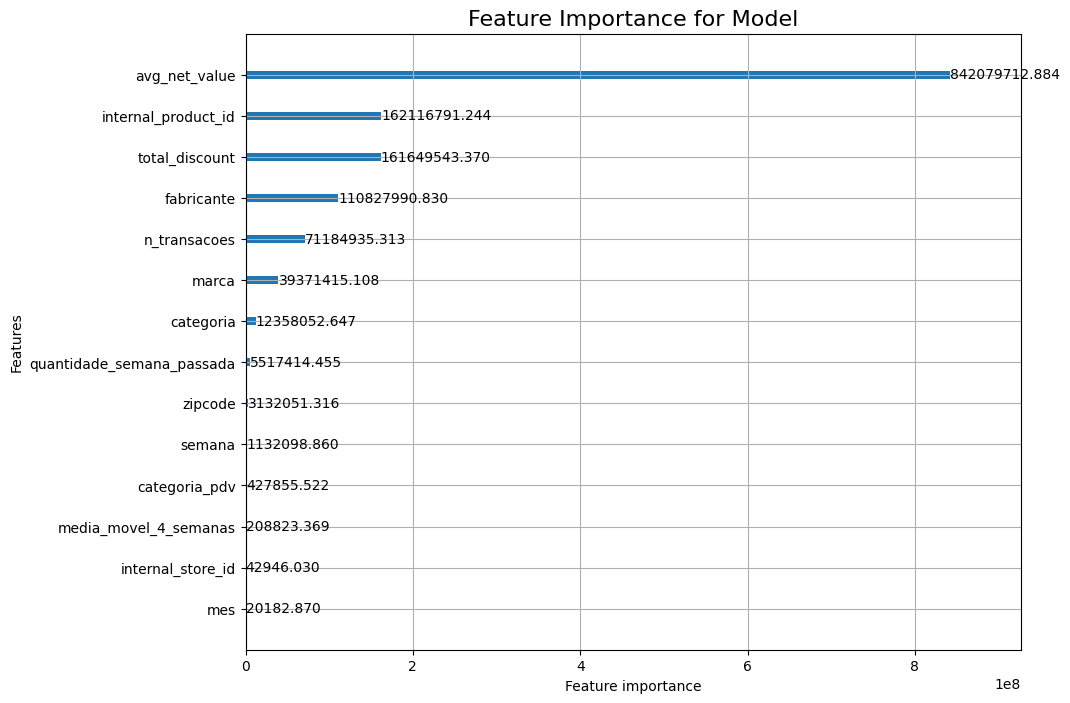

In [ ]:
lgb.plot_importance(
    lgbm,
    figsize=(10, 8),
    max_num_features=16,
    importance_type='gain'
)

plt.title('Feature Importance for Model', fontsize=16)
plt.show()

# 4. Salvando o Modelo e Resultados

In [ ]:
import joblib

filename = 'lgbm_model.pkl'
joblib.dump(lgbm, filename)

['lgbm_model.pkl']

In [58]:
import os
# create a dictionary to hold the model and its categories
model_assets = {
    'model': lgbm,
    'categories': {}
}

categorical_features = X_train.select_dtypes(include='category').columns

for col in categorical_features:
    model_assets['categories'][col] = X_train[col].cat.categories

os.makedirs('models', exist_ok=True)
joblib.dump(model_assets, 'models/lgbm_assets.pkl')

['models/lgbm_assets.pkl']

In [ ]:
existing_pairs = df_model[['internal_store_id', 'internal_product_id']].drop_duplicates()

In [ ]:
prediction_year = 2023
prediction_weeks = [1, 2, 3, 4, 5]
weeks_df = pd.DataFrame({'semana': prediction_weeks})

In [ ]:
future_df = pd.merge(existing_pairs, weeks_df, how='cross')
future_df['ano'] = prediction_year

future_df = pd.merge(future_df, product_features, on='internal_product_id', how='left')
future_df = pd.merge(future_df, store_features, on='internal_store_id', how='left')

In [ ]:
last_known_data = df_model.sort_values(by=['ano', 'semana']).groupby(['internal_store_id', 'internal_product_id']).last().reset_index()
future_df = pd.merge(future_df,
                     last_known_data[['internal_store_id', 'internal_product_id', 'quantidade', 'media_movel_4_semanas', 'avg_net_value', 'total_discount', 'n_transacoes']],
                     on=['internal_store_id', 'internal_product_id'],
                     how='left')
future_df.rename(columns={'quantidade': 'quantidade_semana_passada'}, inplace=True)

/tmp/ipython-input-2785370028.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  last_known_data = df_model.sort_values(by=['ano', 'semana']).groupby(['internal_store_id', 'internal_product_id']).last().reset_index()


In [ ]:
future_df['mes'] = 1
future_df.fillna(0, inplace=True)
future_df.head()

,internal_store_id,internal_product_id,semana,ano,marca,categoria,fabricante,premise,categoria_pdv,zipcode,quantidade_semana_passada,media_movel_4_semanas,avg_net_value,total_discount,n_transacoes,mes
0,1000237487041964405,1837429607327399565,1,2023,Fire Maker Perfect Match IPA,Package,Fire Maker Brewing Co,On Premise,Winery,30175,2.0,1.75,72.240486,0.0,1.0,1
1,1000237487041964405,1837429607327399565,2,2023,Fire Maker Perfect Match IPA,Package,Fire Maker Brewing Co,On Premise,Winery,30175,2.0,1.75,72.240486,0.0,1.0,1
2,1000237487041964405,1837429607327399565,3,2023,Fire Maker Perfect Match IPA,Package,Fire Maker Brewing Co,On Premise,Winery,30175,2.0,1.75,72.240486,0.0,1.0,1
3,1000237487041964405,1837429607327399565,4,2023,Fire Maker Perfect Match IPA,Package,Fire Maker Brewing Co,On Premise,Winery,30175,2.0,1.75,72.240486,0.0,1.0,1
4,1000237487041964405,1837429607327399565,5,2023,Fire Maker Perfect Match IPA,Package,Fire Maker Brewing Co,On Premise,Winery,30175,2.0,1.75,72.240486,0.0,1.0,1


In [52]:
X_future = future_df[features]
categorical_features = X_train.select_dtypes(include='category').columns
for col in categorical_features:
    train_categories = X_train[col].cat.categories
    X_future[col] = pd.Categorical(X_future[col], categories=train_categories)

future_predictions = lgbm.predict(X_future)

df_submission = future_df[['semana', 'internal_store_id', 'internal_product_id']].copy()
df_submission['quantidade'] = future_predictions

df_submission.rename(columns={
    'internal_store_id': 'pdv',
    'internal_product_id': 'produto'
}, inplace=True)

df_submission['quantidade'] = df_submission['quantidade'].round().astype(int)
df_submission.loc[df_submission['quantidade'] < 0, 'quantidade'] = 0

output_filename = 'results.csv'
df_submission.to_csv(
    output_filename,
    sep=';',              # semicolon separator
    encoding='utf-8',
    index=False
)

print(f"\nFile '{output_filename}' created successfully.")
display(df_submission.head())


File 'results.csv' created successfully.


,semana,pdv,produto,quantidade
0,1,1000237487041964405,1837429607327399565,2
1,2,1000237487041964405,1837429607327399565,2
2,3,1000237487041964405,1837429607327399565,2
3,4,1000237487041964405,1837429607327399565,2
4,5,1000237487041964405,1837429607327399565,2


In [57]:
df_submission['quantidade'] = df_submission['quantidade'].round().astype(int)
df_submission.loc[df_submission['quantidade'] < 0, 'quantidade'] = 0

# parquet option
output_filename = 'results.parquet'
df_submission.to_parquet(
    output_filename,
    engine='pyarrow',
    index=False
)

print(f"\nFile '{output_filename}' created successfully.")
display(df_submission.head())


File 'results.parquet' created successfully.


,semana,pdv,produto,quantidade
0,1,1000237487041964405,1837429607327399565,2
1,2,1000237487041964405,1837429607327399565,2
2,3,1000237487041964405,1837429607327399565,2
3,4,1000237487041964405,1837429607327399565,2
4,5,1000237487041964405,1837429607327399565,2


In [53]:
df_submission['quantidade'].describe()

,quantidade
count,5.148360e+06
mean,1.150983e+01
std,3.360369e+01
min,0.000000e+00
25%,1.000000e+00
50%,2.000000e+00
75%,8.000000e+00
max,5.020000e+02
